In [2]:
from matplotlib import pyplot as plt
import fastf1
from fastf1 import utils
import numpy as np
from fastf1 import plotting
from fastf1.core import Laps
import pandas as pd

# Qualifying Lap comparison

In [3]:
fastf1.plotting.setup_mpl(misc_mpl_mods=False, color_scheme='fastf1')

session = fastf1.get_session(2025, 'Japan', 'Q')

session.load()
fast_verstappen = session.laps.pick_drivers('VER').pick_fastest()
fast_norris = session.laps.pick_drivers('NOR').pick_fastest()


req         WARNING 	DEFAULT CACHE ENABLED! (24.0 KB) C:\Users\vini\AppData\Local\Temp\fastf1


core           INFO 	Loading data for Japanese Grand Prix - Qualifying [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO

In [4]:
car_mv = fast_verstappen.get_car_data().add_distance()
car_ln = fast_norris.get_car_data().add_distance()

In [5]:
rbr_color = fastf1.plotting.get_team_color(fast_verstappen['Team'], session=session)
mcl_color = fastf1.plotting.get_team_color(fast_norris['Team'], session=session)

req            INFO 	Using cached data for driver_info


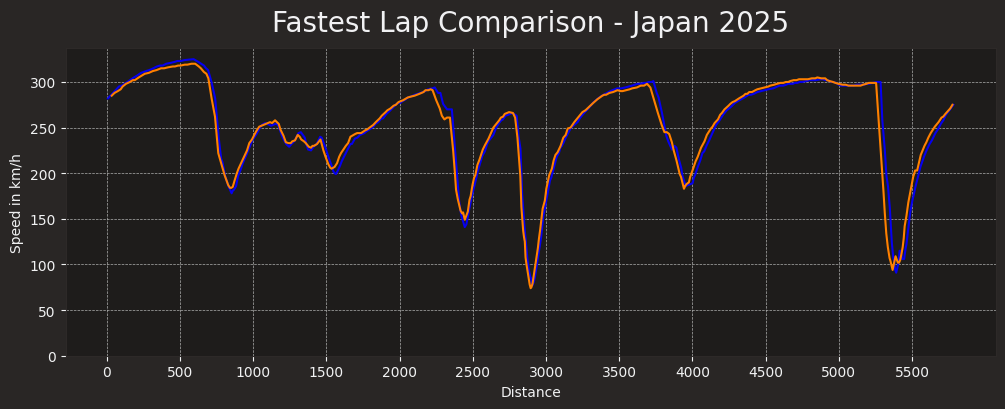

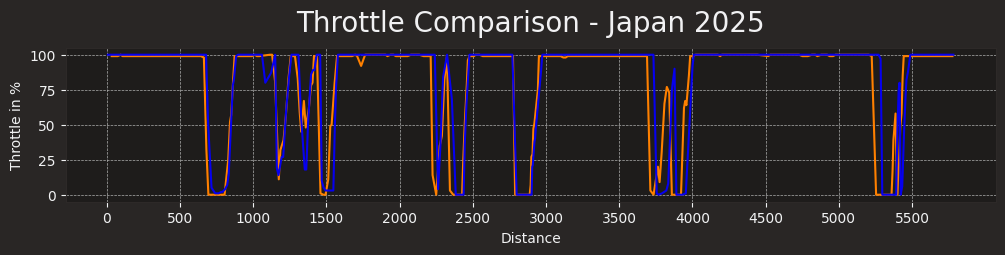

c:\Users\vini\Suzuka2025-VERxNOR-Comparision\.venv\Lib\site-packages\fastf1\utils.py:89: FutureWarning: `utils.delta_time` is considered deprecated and willbe modified or removed in a future release because it hasa tendency to give inaccurate results.
  warnings.warn("`utils.delta_time` is considered deprecated and will"


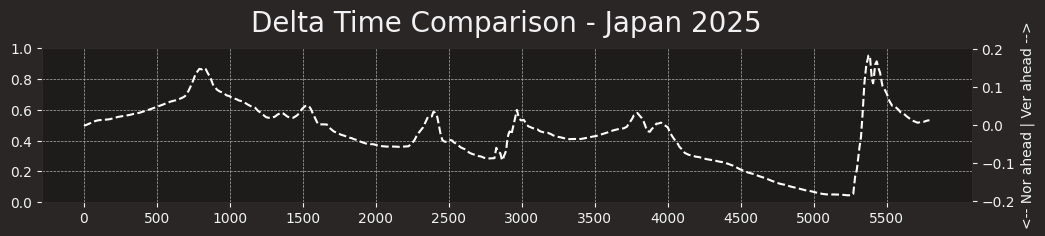

In [6]:
fig, ax = plt.subplots(figsize=(12, 4), dpi=100)
ax.set_title('Fastest Lap Comparison - Japan 2025', fontsize=20)

ax.plot(car_mv['Distance'], car_mv['Speed'], color=rbr_color, label='VER')
ax.plot(car_ln['Distance'], car_ln['Speed'], color=mcl_color, label='NOR')

ax.set_xlabel('Distance')
ax.set_ylabel('Speed in km/h')

ax.set_xticks(np.arange(0, car_mv['Distance'].max(), 500))  # Intervalos no eixo X
ax.set_yticks(np.arange(0, max(car_mv['Speed'].max(), car_ln['Speed'].max()), 50)) # Intervalos no eixo Y
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

fig, ax = plt.subplots(figsize=(12, 2), dpi=100)
ax.set_title('Throttle Comparison - Japan 2025', fontsize=20)
ax.plot(car_ln['Distance'], car_ln['Throttle'], color=mcl_color, label='NOR')
ax.plot(car_mv['Distance'], car_mv['Throttle'], color=rbr_color, label='VER')

ax.set_xticks(np.arange(0, car_mv['Distance'].max(), 500))  # Intervalos no eixo X

ax.set_xlabel('Distance')
ax.set_ylabel('Throttle in %')

ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

delta_time, ref_tel, compare_tel = utils.delta_time(fast_verstappen, fast_norris)
# Verstappen is the reference driver, Norris is the comparison driver

fig, ax = plt.subplots(figsize=(12, 2), dpi=100)
ax.set_title('Delta Time Comparison - Japan 2025', fontsize=20)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_xticks(np.arange(0, car_mv['Distance'].max(), 500))  # Intervalos no eixo X

twin = ax.twinx()
twin.plot(ref_tel['Distance'], delta_time, '--', color='white')
twin.set_ylabel("<-- Nor ahead | Ver ahead -->")

plt.show()


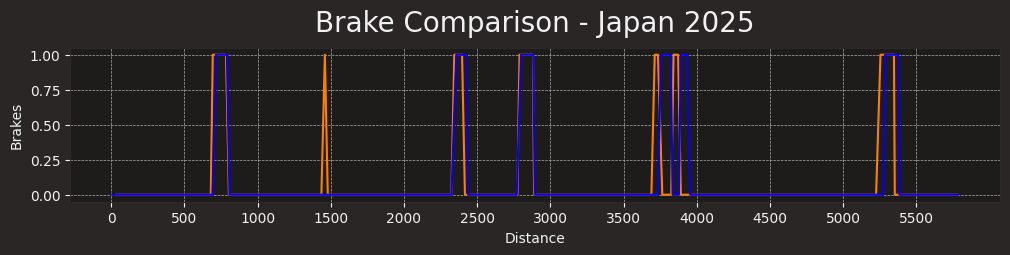

In [7]:

fig, ax = plt.subplots(figsize=(12, 2), dpi=100)
ax.set_title('Brake Comparison - Japan 2025', fontsize=20)
ax.plot(car_ln['Distance'], car_ln['Brake'], color=mcl_color, label='NOR')
ax.plot(car_mv['Distance'], car_mv['Brake'], color=rbr_color, label='VER')

ax.set_xticks(np.arange(0, car_mv['Distance'].max(), 500))  # Intervalos no eixo X

ax.set_xlabel('Distance')
ax.set_ylabel('Brakes')

ax.grid(True, which='both', linestyle='--', linewidth=0.5)

### • Based on this analysis, it' possible to conclude that even though the cars were running with similar downforce specs, the RedBull car is still likely to have some balance issues. In turns 4, 5, and 6 (around 1000m–1500m), the RB21 has to lift off the throttle much more than the MCL39
### • The RedBull car is likely to have some balance issues. In turns 4, 5, and 6 (around Distance 1000–1500), the RB21 has to lift off the throttle much more than the MCL39.
### • Verstappen gained the most time in the last chicane, braking considerably later than Norris and everyone else, which secured him pole position

# Engine comparison

In [30]:
fastf1.plotting.setup_mpl(mpl_timedelta_support=True, misc_mpl_mods=False,
                          color_scheme=None)

drivers = pd.unique(session.laps['Driver'])
print(drivers)

['VER' 'NOR' 'PIA' 'LEC' 'RUS' 'ANT' 'HAD' 'HAM' 'ALB' 'BEA' 'GAS' 'SAI'
 'ALO' 'LAW' 'TSU' 'HUL' 'BOR' 'OCO' 'DOO' 'STR']


In [ ]:
mercedes_engines = ['12', '63', '4', '81', '14', '18', '55', '23']
rbr_drivers = ['1', '22', '6', '30']
reference_driver = session.laps.pick_fastest()
reference_time = reference_driver['LapTime'].total_seconds()

drivers_data = []

def process_driver(driver, is_rbr=False):
    try:
        # Pegar a volta mais rápida do piloto
        fastest_lap = session.laps.pick_drivers(driver).pick_fastest()
        
        if fastest_lap is not None:
            # Obter a velocidade máxima
            top_speed = fastest_lap['SpeedST']  # Velocidade na speed trap
            
            # Calcular a diferença de pace (em segundos)
            lap_time = fastest_lap['LapTime'].total_seconds()
            pace_diff = lap_time - reference_time
            
            # Adicionar os dados à lista
            drivers_data.append({
                'Driver': driver,
                'TopSpeed': top_speed,
                'PaceDiff': pace_diff,
                'DriverCode': fastest_lap['Driver'],
                'LapTime': lap_time,
                'IsRedBull': is_rbr
            })
        else:
            print(f"Não foi possível encontrar a volta mais rápida para o piloto {driver}")
    except Exception as e:
        print(f"Erro ao processar dados do piloto {driver}: {e}")

# Processar pilotos padrão (em cinza)
for driver in mercedes_engines:
    process_driver(driver, is_rbr=False)
    
# Processar pilotos da Red Bull (em azul)
for driver in rbr_drivers:
    process_driver(driver, is_rbr=True)

# Criar DataFrame para facilitar o plotting
df = pd.DataFrame(drivers_data)


Piloto 12: TopSpeed=295.0km/h, PaceDiff=0.572s
Piloto 63: TopSpeed=297.0km/h, PaceDiff=0.335s
Piloto 4: TopSpeed=295.0km/h, PaceDiff=0.012s
Piloto 81: TopSpeed=294.0km/h, PaceDiff=0.044s
Piloto 14: TopSpeed=294.0km/h, PaceDiff=0.914s
Piloto 18: TopSpeed=295.0km/h, PaceDiff=2.288s
Piloto 55: TopSpeed=298.0km/h, PaceDiff=0.853s
Piloto 23: TopSpeed=294.0km/h, PaceDiff=0.632s
Piloto 1: TopSpeed=295.0km/h, PaceDiff=0.000s
Piloto 22: TopSpeed=296.0km/h, PaceDiff=0.984s
Piloto 6: TopSpeed=295.0km/h, PaceDiff=0.586s
Piloto 30: TopSpeed=296.0km/h, PaceDiff=0.923s


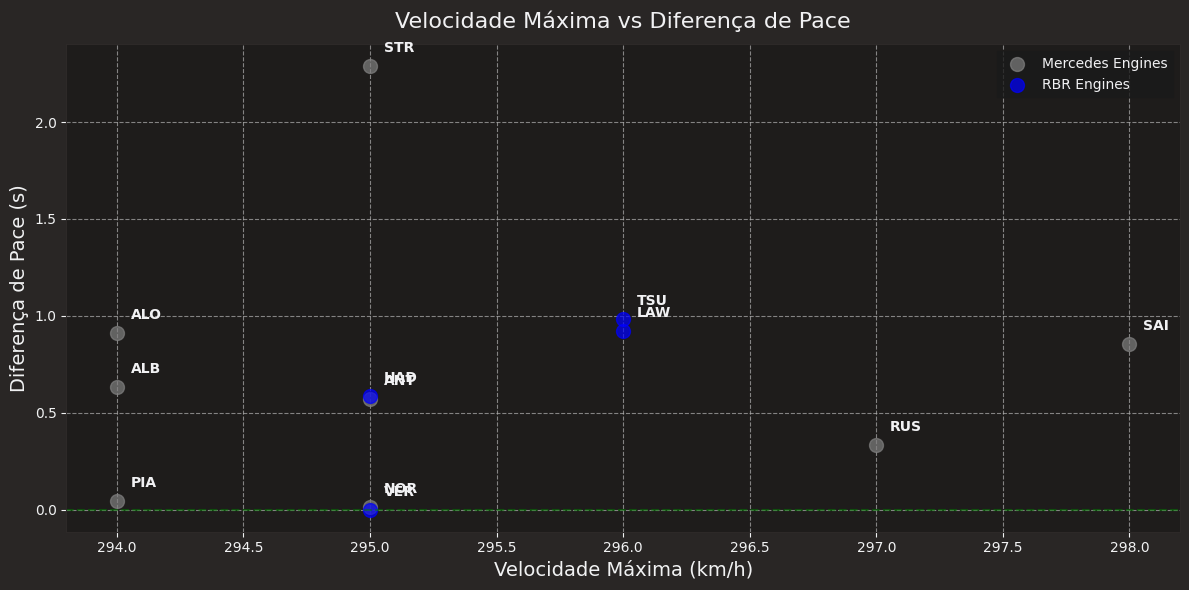

In [35]:
plt.figure(figsize=(12, 6))

# Filtrar os dados para pilotos normais e Red Bull
rbr_df = df[df['IsRedBull'] == True]
other_df = df[df['IsRedBull'] == False]

# Scatter plot com os pilotos em cinza
plt.scatter(other_df['TopSpeed'], other_df['PaceDiff'], color='gray', s=100, alpha=0.7, label='Mercedes Engines')

# Scatter plot com os pilotos Red Bull em azul
plt.scatter(rbr_df['TopSpeed'], rbr_df['PaceDiff'], color='blue', s=100, alpha=0.7, label='RBR Engines')

# Adicionar labels para cada ponto
for i, row in df.iterrows():
    plt.annotate(row['DriverCode'], 
                 (row['TopSpeed'], row['PaceDiff']),
                 xytext=(10, 10),  # Aumentado de (5, 5) para (10, 10)
                 textcoords='offset points',
                 fontweight='bold',
                    fontsize=10,)
# Configurar o gráfico
plt.title('Velocidade Máxima vs Diferença de Pace', fontsize=16)
plt.xlabel('Velocidade Máxima (km/h)', fontsize=14)
plt.ylabel('Diferença de Pace (s)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Adicionar legenda
plt.legend(loc='upper right')

# Adicionar linhas de referência
plt.axhline(y=0, color='green', linestyle='--', alpha=0.5)  # Linha do piloto de referência

# Melhorar a visualização
plt.tight_layout()
plt.savefig('pace_vs_speed.png', dpi=500)
plt.show()

# Race Pace Comparison

In [6]:
Race = fastf1.get_session(2025, 'Japan', 'R')

Race.load()
pace_ver = Race.laps.pick_drivers('VER').pick_quicklaps()
pace_nor = Race.laps.pick_drivers('NOR').pick_quicklaps()
pace_pia = Race.laps.pick_drivers('PIA').pick_quicklaps()

core           INFO 	Loading data for Japanese Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No c

In [7]:
pace_ver['LapTime'] = pace_ver['LapTime'].dt.total_seconds()
pace_nor['LapTime'] = pace_nor['LapTime'].dt.total_seconds()
pace_pia['LapTime'] = pace_pia['LapTime'].dt.total_seconds()

/var/folders/1m/898rjvbd6jb9zl60yhl1rgnr0000gn/T/ipykernel_36317/3363891719.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pace_pia['LapTime'] = pace_pia['LapTime'].dt.total_seconds()


### • 10KG of added weight is about 0.3s in lap time. By dividing the maximum starting fuel (110kg) by the total of laps of the Grand Prix (53 for the Japanese Grand Prix), we have the car's average fuel consumption
### • That is the simplest way (and more effective way) to correct the laptimes without insider informations 

In [8]:
combustivel_inicial = 110
voltas = 53
consumo_medio = combustivel_inicial / voltas
dez_kg = 0.3

tempo_real_ver = pace_ver['LapTime']
tempo_real_nor = pace_nor['LapTime']
tempo_real_pia = pace_pia['LapTime']

tempos_ver_neutralizados = []
temos_nor_neutralizados = []
tempos_pia_neutralizados = []

for volta, tempo_real_ver in enumerate(tempo_real_ver, start=1):
    combustivel_atual = combustivel_inicial - (volta * consumo_medio)
    ajuste = (combustivel_atual / 10) * dez_kg
    tempo_neutralizado = tempo_real_ver - ajuste
    tempos_ver_neutralizados.append(tempo_neutralizado)
    
for volta, tempo_real_nor in enumerate(tempo_real_nor, start=1):
    combustivel_atual = combustivel_inicial - (volta * consumo_medio)
    ajuste = (combustivel_atual / 10) * dez_kg
    tempo_neutralizado = tempo_real_nor - ajuste
    temos_nor_neutralizados.append(tempo_neutralizado)

for volta, tempo_real_pia in enumerate(pace_pia['LapTime'], start=1):
    combustivel_atual = combustivel_inicial - (volta * consumo_medio)
    ajuste = (combustivel_atual / 10) * dez_kg
    tempo_neutralizado = tempo_real_pia - ajuste
    tempos_pia_neutralizados.append(tempo_neutralizado)


pace_ver['LapTime'] = tempos_ver_neutralizados
pace_nor['LapTime'] = temos_nor_neutralizados
pace_pia['LapTime'] = tempos_pia_neutralizados

/var/folders/1m/898rjvbd6jb9zl60yhl1rgnr0000gn/T/ipykernel_36317/713726392.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pace_pia['LapTime'] = tempos_pia_neutralizados


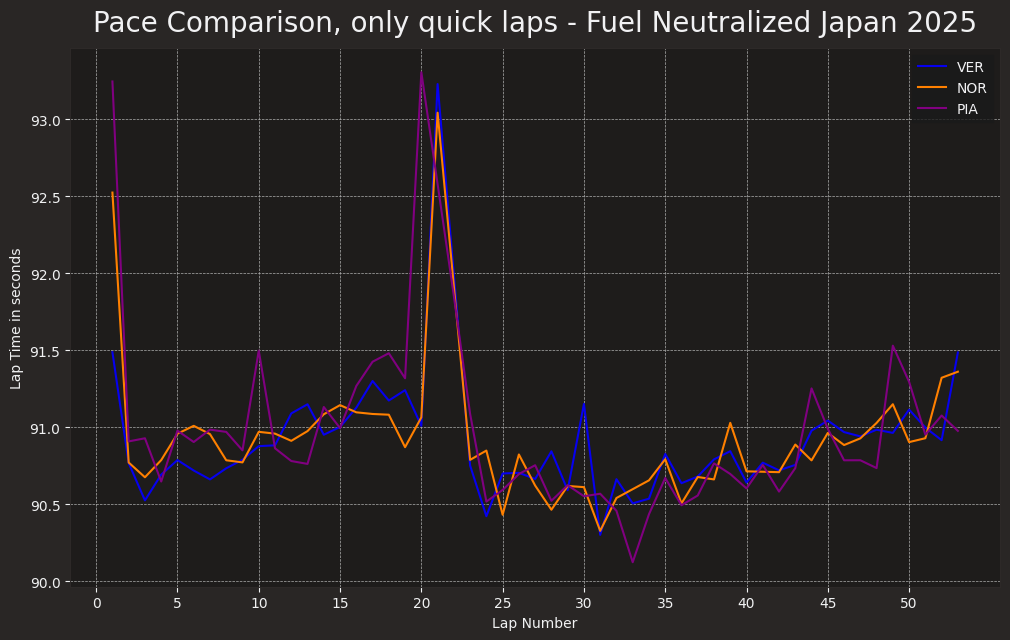

In [9]:
fig, ax = plt.subplots(figsize=(12, 7), dpi=100)
ax.set_title('Pace Comparison, only quick laps - Fuel Neutralized Japan 2025', fontsize=20)

ax.plot(pace_ver['LapNumber'], pace_ver['LapTime'], color=rbr_color, label='VER')
ax.plot(pace_nor['LapNumber'], pace_nor['LapTime'], color=mcl_color, label='NOR')
ax.plot(pace_pia['LapNumber'], pace_pia['LapTime'], color='purple', label='PIA')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

ax.set_xticks(np.arange(0, pace_ver['LapNumber'].max(), 5))  # Intervalos no eixo X

ax.set_xlabel('Lap Number')
ax.set_ylabel('Lap Time in seconds')
ax.legend()

plt.show()


In [10]:
media_ver = pace_ver['LapTime'].mean()
media_nor = pace_nor['LapTime'].mean()
media_pia = pace_pia['LapTime'].mean()
print(f"Media VER: {media_ver:.3f}")
print(f"Media NOR: {media_nor:.3f}")
print(f"Media PIA: {media_pia:.3f}")
print(f"Delta Ver - Pia: {media_ver - media_pia:.3f}")
print(f"Delta Ver - Nor: {media_ver - media_nor:.3f}")
print(f"Delta Nor - Pia: {media_nor - media_pia:.3f}")

Media VER: 90.906
Media NOR: 90.919
Media PIA: 90.967
Delta Ver - Pia: -0.061
Delta Ver - Nor: -0.014
Delta Nor - Pia: -0.047


### • Although Verstappen's pace was only 0.014 faster than Norris's, the British driver was unable to overtake him, likely due to the car's instability in dirty air.
### • Piastri, who also had a similar pace to Norris was also unable to overtake him